In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print "OpenCV Version : %s " % cv2.__version__

OpenCV Version : 2.4.12 


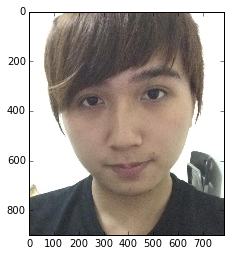

In [4]:
PATH = "yusheng.jpg"
image = cv2.imread(PATH)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()